# NLP analysis and classification of subReddits


_Continued. To see the data scrape and initial problem statement exploration, please see:_
[Report1: scrape](https://git.generalassemb.ly/cotica/project_3/blob/main/code/Project-3-Scraping-Subreddits-data-pull.ipynb).

GENERAL NOTE ON ATTRIBUTION: The ideas and coding techniques applied throughout this work are heavily influenced thanks to collaboration with and numerous reviews by Gwen Rathgeber. This report would not have been possible without substantial input from Gwen.


## Part II - Cleaning & elementary EDA
---

We'll import all our required libraries up here.

In [95]:
#import all prospective libraries

import pandas as pd, \
       numpy as np, \
       requests, time, nltk, \
       datetime as dt, \
       matplotlib.pyplot as plt, seaborn as sns, \
       re, os #regex


#NLP transformers
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

import gensim.downloader as api #allows us to get word2vec anf glove embeddings that we need
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, \
                                            TfidfVectorizer


#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, \
                              ExtraTreesClassifier, \
                              BaggingClassifier,
                              GradientBoostingClassifier, \
                              AdaBoostClassifier, \
                              VotingClassifier)

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from xgboost import XGBRegressor, XGBClassifier
from sklearn.naive_bayes import MultinomialNB


#metrics / model preprocessing
from sklearn.metrics import (accuracy_score, confusion_matrix, \
                             plot_confusion_matrix, \
                             recall_score, precision_score)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV, \
                                    cross_val_score, \
                                    RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from scipy.stats import uniform, loguniform

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

#show grid on plots
sns.set_style('darkgrid')

In [2]:
#pip install python-Levenshtein
#this is for the gensim.similarities.levenshtein submodule

- - - 

### Pull in the files from our scrapes

In [3]:
movie_deets2 = pd.read_csv('../data_outputs/good_movie_deets2.csv')
bad_deets2 = pd.read_csv('../data_outputs/bad_movie_deets2.csv')

### Get basic stats

Let's look at basic stats about our data.

How many records do we have, prior to cleaning?

In [4]:
movie_deets2.shape

(8805, 9)

In [5]:
bad_deets2.shape

(8180, 9)

What did we pull in?

In [6]:
movie_deets2.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"Listen,share,repost ""culgrin d mayor"" Africa gorilla volume 1 EP on all PLATFORMS",NaN,MovieDetails,1619213155,culgrin1,False,1,0,2021-04-23
1,"In Repo Man (1984), Miller says to Otto “suppose you're thinkin' about a plate o' shrimp. Suddenly someone'll say, plate, or shrimp, or plate o' shrimp out the blue” as an example of his concept o...",NaN,MovieDetails,1619214866,VictorBlimpmuscle,False,1,12,2021-04-23


In [7]:
bad_deets2.head(2)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1619214935,Wuz314159,False,1,1,2021-04-23
1,"The Nightmare Before Christmas (1993), when he arrives at Christmas Town, Jack sings ""what's this? There's white things in the air"". 22 seconds later he sings ""there are children throwing snowball...",NaN,shittymoviedetails,1619217853,Nerf_Herder86,False,1,0,2021-04-23


Let's actually merge our dataframes to make it easier for processing.

In [8]:
#pd.concat([df1, df2])
df = pd.concat([bad_deets2, movie_deets2])
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1619214935,Wuz314159,False,1,1,2021-04-23


In [9]:
df.shape

(16985, 9)

What data types are we dealing with?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16985 entries, 0 to 8804
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         16985 non-null  object
 1   selftext      2260 non-null   object
 2   subreddit     16985 non-null  object
 3   created_utc   16985 non-null  int64 
 4   author        16985 non-null  object
 5   is_self       16985 non-null  bool  
 6   score         16985 non-null  int64 
 7   num_comments  16985 non-null  int64 
 8   timestamp     16985 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 1.2+ MB


A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling.

A few objects, like text fields, are expected, and will need to be transformed / vectorized for modeling.

Let's also convert the time stamps to a usable format, just in case they come in handy for modeling. Further, the UTC is actually not really something we want in our model, and it's not really numeric either (it's a datetime concept if anything). Let's take care of that as well.

In [11]:
#convert time stamps
#.apply(pd.to_datetime) - ref.: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
df['timestamp'] = df['timestamp'].apply(pd.to_datetime)
df['created_utc'] = df['created_utc'].apply(pd.to_datetime)

Now we can try to obtain basic descriptive stats.

In [12]:
df.describe().round(1)

,score,num_comments
count,16985.0,16985.0
mean,82.5,17.4
std,1717.4,100.1
min,0.0,0.0
25%,1.0,0.0
50%,1.0,2.0
75%,1.0,5.0
max,72489.0,3368.0


Not much to look at here at the moment. The notables are the distribution of comments and just the gaping wide spread in our data. We'll want to perform some more specific distribution analyses a little down the road, once done with the cleaning, to make more sense out of these stats.

Where might we have issues with missing data?

In [13]:
df.isnull().sum()

title               0
selftext        14725
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

- - - 

### Imputation and cleaning strategy

Our strategy is to first remove anything with selftext appearing to have been deleted. Even though these are not read as nulls, they effectively are, for our purposes.

We knew that we'd have quite a few issues with missing self-text, when we shose to scrape unfiltered data. To remedy this, we could impute all nulls where self text is missing with the post's title, but this might result in inadvertent text duplicates when we train our model. So, instead, we are going to engineer a new column and merge the self-text and title text. _Note: Attribution for the idea to Riley R._

We can, if we would like to, further dedupe and get rid of ostensibly spammy looking posts, by adding stop words like "repost", "reshare", as well as dropping any dominant authors or ones that sound spammy ("bot", "auto", "moderator").

We will also need to get rid of any link references.

Okay, let's start by dropping anything with the word "removed" or "deleted". It's a tiny portion of our set, so I am not super worried about losing those rows of data.

In [14]:
#df[~df['col'].str.contains('value1|value2')]
#syntactic ref from https://stackoverflow.com/questions/52297740/typeerror-bad-operand-type-for-unary-float

df = df[~df['selftext'].str.contains('deleted|removed', na=False)]

#df = df[df.selftext != 'deleted']
#df = df[df.selftext != 'removed']

In [15]:
#check
df.head(1)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp
0,"In the movie Bullworth (1998), a police officer is seen not shooting black people.",NaN,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23


Let's confirm that those bad rows are gone.

In [16]:
#check again that removed and deleted selftexts are no longer in frame
df['selftext'].value_counts().sort_values(ascending=False)[:2]

&gt;!In "The Girl with the Dragon Tattoo", Christopher Plummer tells Daniel Craig's character "The man who hires the detective should always be kept on the suspects list." In "Knives Out", Craig is hired by Ransom Drysdale (Chris Evans) to investigate the murder of Harlan Thrombey (Christopher Plummer), which Ransom himself committed.!&lt;    2
[https://i.imgur.com/5yFzqdk.jpg](https://i.imgur.com/5yFzqdk.jpg)                                                                                                                                                                                                                                                                                       2
Name: selftext, dtype: int64

We should see the dropped rows reflected in the shape.

In [17]:
#Confirm dataframe has shrunk
df.shape

(15417, 9)

Finally, the nulls should still be intact -- we are going to take care of that in a moment.

In [18]:
df.isnull().sum()

title               0
selftext        14725
subreddit           0
created_utc         0
author              0
is_self             0
score               0
num_comments        0
timestamp           0
dtype: int64

We also need to get rid of the link mentions and junk in the strings.

In [19]:
#df['column'] = df['column'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#from https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe/51994366

df['selftext'] = df['selftext'].replace(r'http\S+', '', regex=True).replace(
    r'www\S+', '', regex=True).replace(r'\&amp\S+', '', regex=True)

In [20]:
type(df['selftext'])

pandas.core.series.Series

In [21]:
#from https://stackoverflow.com/questions/44227748/removing-newlines-from-messy-strings-in-pandas-dataframe-cells

df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

df = df.replace(r'\\n','', regex=True) 

In [22]:
#Thanks to Aderinsola, Dan and Riley R. for collaboration on this code
df = df.replace(r'[^a-zA-Z0-9]', ' ', regex=True)

We need an imputation strategy for the NaNs. I'm choosing to fill them in with spaces.

We will then merge the self-text and title columns as a single text column, to vectorize and train on later.

In [23]:
#nuke nulls
df['selftext'].fillna('', inplace=True)

In [24]:
#get new all-text column.
df['all_text'] = df['title'] + '. ' + df['selftext']

#check result
df.head(25).sort_values(by = 'selftext', ascending = False)

,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp,all_text
0,In the movie Bullworth 1998 a police officer is seen not shooting black people,,shittymoviedetails,1970-01-01 00:00:01.619214935,Wuz314159,False,1,1,2021-04-23,In the movie Bullworth 1998 a police officer is seen not shooting black people .
13,After the commercial success of Kitchen Gun and Toilet Grenade Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick Chapter 2,,shittymoviedetails,1970-01-01 00:00:01.619251458,Raoshard,False,1,46,2021-04-24,After the commercial success of Kitchen Gun and Toilet Grenade Peter Serafinowicz expanded his business to offer a larger variety of cleaning products in John Wick Chapter 2.
23,Guy makes his interestingly bizarre rendition that s addictive,,shittymoviedetails,1970-01-01 00:00:01.619283112,TitsAmazing,False,1,0,2021-04-24,Guy makes his interestingly bizarre rendition that s addictive.
22,The film title No Country For Old Men 2007 refers to the fact that Florida is not in fact a country It is a state,,shittymoviedetails,1970-01-01 00:00:01.619282093,NuclearJesusMan,False,1,5,2021-04-24,The film title No Country For Old Men 2007 refers to the fact that Florida is not in fact a country It is a state .
21,In 2001 A Space Odyssey 1968 much of the film focuses on characters walking slowly in silence This is a reference to the fact that holy fuck this movie is boring as all hell,,shittymoviedetails,1970-01-01 00:00:01.619281182,NuclearJesusMan,False,1,20,2021-04-24,In 2001 A Space Odyssey 1968 much of the film focuses on characters walking slowly in silence This is a reference to the fact that holy fuck this movie is boring as all hell .
20,In Captain America The Winter Soldier 2014 the Winter Soldier looks like a crab in this scene This is a reference to the actors name Sebastian who is a crab in another Disney film The Litt...,,shittymoviedetails,1970-01-01 00:00:01.619280462,KennKennyKenKen,False,1,61,2021-04-24,In Captain America The Winter Soldier 2014 the Winter Soldier looks like a crab in this scene This is a reference to the actors name Sebastian who is a crab in another Disney film The Litt...
19,In Justice League 2021 the kid from the liquor store whom Bruce was referring to is actually McLovin,,shittymoviedetails,1970-01-01 00:00:01.619278471,pale guy,False,1,0,2021-04-24,In Justice League 2021 the kid from the liquor store whom Bruce was referring to is actually McLovin .
18,Captain America 4 TBA has recently been announced Here is the leaked trailer,,shittymoviedetails,1970-01-01 00:00:01.619277392,KennKennyKenKen,False,1,13,2021-04-24,Captain America 4 TBA has recently been announced Here is the leaked trailer .
17,In The Curious Case of Benjamin Button 2008 Brad Pitt became old because fight clubs can really take a toll on a guy,,shittymoviedetails,1970-01-01 00:00:01.619275733,pale guy,False,1,0,2021-04-24,In The Curious Case of Benjamin Button 2008 Brad Pitt became old because fight clubs can really take a toll on a guy .
16,in mortal kombat Hanzo says Cole Young don t let the bloodline die in Japanese Cole Young,,shittymoviedetails,1970-01-01 00:00:01.619270578,invertedparadX,False,1,0,2021-04-24,in mortal kombat Hanzo says Cole Young don t let the bloodline die in Japanese Cole Young .


In [25]:
df['selftext'].sort_values(ascending=False)

6176                                                                                                                                                             tl dr   outraged  Michael Keaton must respond 
3713                                                             the same score that is used in the infamous  Save Martha  scene in the BvS is used in the final monologue that Diana gives to the whole world 
3829            ok so in the last spiderman movie FFH  in the final scene we see J  K  Simmons playing as J  Jonah Jameson but he also play the same role in thr first Spider Man trilogy  whats that all about
5981                                                                                                                                                                                                       lmao
880     in Madagascar 2005 the beach scene gloria   the hippo   come out of the box with starfish at her chest and a crab at her    underbelly    she then says   alrigh

In [26]:
#get rid of spammy text / authors by creating stop words list -- or do this underneath,
#in the NLP part -- time permitting

--- 

### Analysis

Now that we are more or less done cleaning, let's understand the density and usefulness of our content, by analyzing the volume of comments and looking for the richness of the text columns.

We will be able to perform additional text analysis later on, once we have transformed (vectorized) our text.

First, let's take a look at the distribution of posts by the volume of comments.

In [27]:
df['num_comments'].value_counts()[:50]

0     4073
2     2414
1     1865
3     1413
4     1117
5      657
6      506
7      352
8      312
9      233
10     217
11     174
12     169
13     127
14     117
15      86
16      84
17      68
18      65
20      63
19      52
22      44
21      38
23      35
26      34
25      29
27      27
24      26
30      22
28      21
33      21
36      20
29      18
41      17
31      16
35      16
37      15
42      13
34      13
32      13
39      13
54      12
45      11
51      10
46       9
57       9
48       9
44       8
47       8
43       7
Name: num_comments, dtype: int64

In [28]:
df['num_comments'].mean()

18.974573522734644

In [29]:
df['num_comments'].mode()

0    0
dtype: int64

In [30]:
df['num_comments'].median()

2.0

In [31]:
df['num_comments'].max()

3368

Judging from this, the vast majority of posts have no comments at all. The average number of comments is 18, although there are also extreme outliers exceeding 1000 comments that we expect to add noise to the model; BUT, they can also be meaningful in indicating a popular post, so we are not necessarily going to get rid of it on the merit that it may skew our data, because it may be some kind of a signal still.

Let's visualize this.

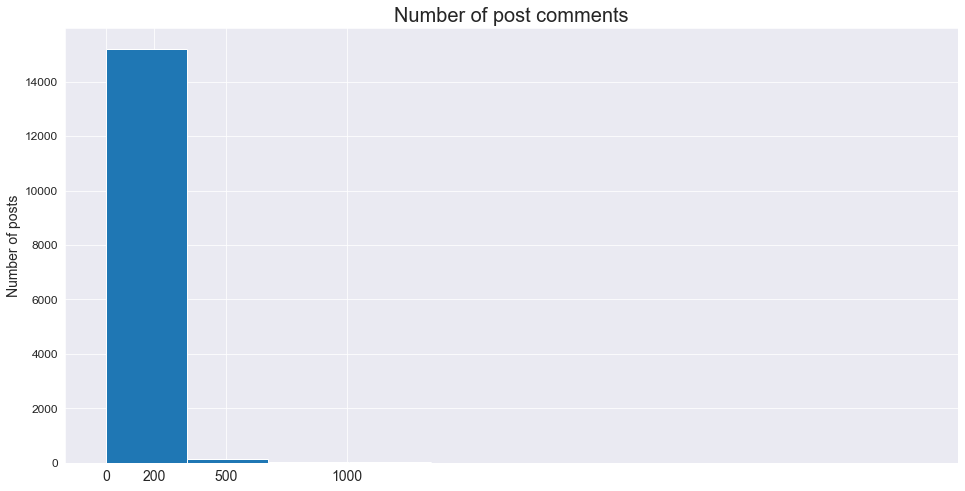

In [32]:
#code ref from Gwen's lab review lesson 4/27/2021

plt.figure(figsize = (16,8));
df['num_comments'].plot(kind='hist');
plt.title('Number of post comments', size =20);
plt.xticks([0, 200, 500, 1000], size=14);
plt.yticks(size=12);
plt.ylabel('Number of posts', size=14);

Now let's look at distribution by authors. Let's see if any stick out as dominant, which can either mean that they are highly engaged on Reddit, or it could be a signal of spam.

Further, we might want to cross-validate if any others appear across _multiple_ of our subReddits!

In [33]:
df['author'].value_counts()[:50] #get only unique

Numerous Lemon          282
Tokyono                 191
pale guy                154
random guy somewhere    138
klsi832                 108
Comic Book Reader        92
sirsquid                 82
alizamessy               63
VictorBlimpmuscle        53
 deleted                 50
KscILLBILL               46
ToyVaren                 45
invertedparadX           43
SpaceMyopia              41
james 1990               40
RayInRed                 31
lopezjessy               30
Jack Earth 2             26
skyfall91404             25
Iamnotbroke              25
JoshuaCalledMe           24
Russian Bagel            24
Prize Guest              24
zzuhruf                  23
legalbagelbeagle         22
KermitTheFraud92         21
RickySmith2005           21
ShaneMP01                20
MattTheSmithers          19
AnishNoor92              19
Gyros45                  19
SleepyGary5              19
hearzy09                 18
Zedfourkay               17
SteveReddon              16
Art0001             

In [34]:
df['author'].value_counts().mean()

1.7088228774107737

We do have some authors that have posted hundreds of posts here, with an average author posting approximately twice. But nothing really obviously sticks out as concerning, at the moment, based on the author's handle alone -- that is, if we were looking for glaringly "spammy" signals with a naked eye (i.e. sans any spam detection machine like spam vs. ham). There are a few humorous handles, and also a number that show that the author's handle is "deleted", which we take to mean no longer active. Still, that's a small subset of the data that should have minimal bearing on it.

(We can check for the word 'repost' and 'reshare' as well; although we should have hopefully gotten rid of most of that content noise by stripping out the URLs from the text fields earlier.)

But how many unique authors are there?

In [35]:
#unique authors
#from Gwen's NLP lab review
len(df['author'].unique())

9022

This checks out, given that we saw just under 2 posts / author on average earlier.

What if authors post to more than one of the subreddits?

In [36]:
# I want to be able to do groupby's the old fashioned way! Thanks for the find to Riley Robertson!
! pip install -U pandasql

In [37]:
#docstring: https://pypi.org/project/pandasql/
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def pysqldf(q):
    #add this to your script if you get tired of calling locals()
    return sqldf(q, globals())

In [38]:
#groupby the authors by subreddit -- check query construct is returning, what we want!
#fix this w/ Gwen's query (posted during 4/19 BH), if time, or kill
df = df


q = """
    SELECT DISTINCT
           count(selftext) as posts,
           subreddit,
           author
           
           FROM
              df
           GROUP BY
              author
           ORDER BY
              subreddit;
              
"""
print(pysqldf(q).head())

   posts     subreddit                author
0      1  MovieDetails           Godzilla   
1      1  MovieDetails                 BMO  
2      1  MovieDetails    Hello my name is  
3      1  MovieDetails            Leonardo  
4      1  MovieDetails        Reginaphalange


Let's go ahead and see when most of our posts are from.

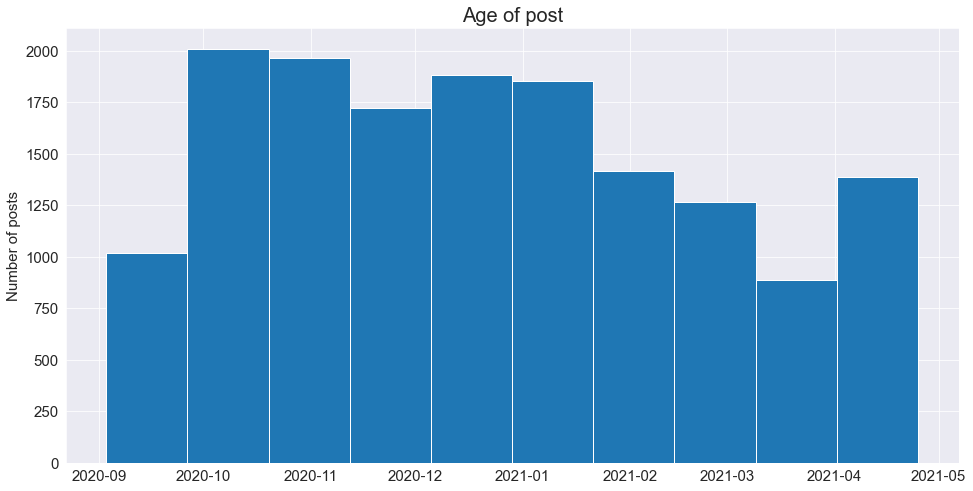

In [39]:
#get post age
plt.figure(figsize = (16, 8))
plt.title('Age of post', size = 20);
df['timestamp'].hist();
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Number of posts', size = 15);

Our posts come from September 2020 to present. ( _Note: this may be a function of how far back we scraped and not in itself meaningful. This was an attempt to find possible seasonality, but there isn't really a pattern I can establish here, and it would be more meaningful to look at a year+ worth's._ )

Finally, let's look at the distribution of original posts, compared to reposts.

In [40]:
df['is_self'].value_counts(normalize=True).round(2)

False    0.94
True     0.06
Name: is_self, dtype: float64

In [41]:
#strip out repost / reshare stuff (if time)

As we can see, most posts are actually reposts in our threads, and we anticipate that the overall quality of our posts might thus be on the lower side.

So how well do most posts score?

(More on this here: [What do Reddit post scores mean?](https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F).)

In [42]:
df['score'].mean()

90.47869235259778

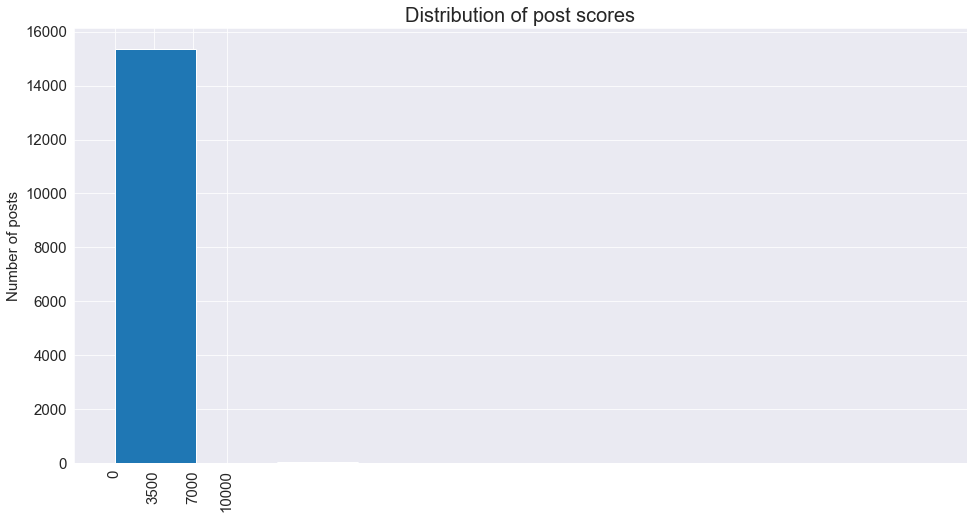

In [43]:
#dist of scores
plt.figure(figsize = (16,8))
df['score'].plot(kind = 'hist');
plt.title('Distribution of post scores', size= 20)
plt.yticks(size=15)
plt.xticks([0, 3500, 7000, 10_000], size=15,rotation = 90)
plt.ylabel('Number of posts', size = 15);

Looks like this is about all we can do, before further transformation.

- - -

## Part III: NLP & feature eng

In [44]:
df.columns

Index(['title', 'selftext', 'subreddit', 'created_utc', 'author', 'is_self',
       'score', 'num_comments', 'timestamp', 'all_text'],
      dtype='object')

### NLP processing and general modeling workflow

Model workflow review ( _thanks, Heather R.!_ ):

1. We will perform sentiment analysis on the whole dataset and get polarity scores
2. Vectorize (**small data leakage)
3. We will train test split, using the sentiment scores (either filtered or compound), to set up the X matrix
4. We will then fit-transform to X-train and transform on X-test and vectorize. Note 1: setting max features, stopwords can help control the size of the data here. Note 2: only pull out the X train, excluding sentiment scores (because only text data needs to be vectorized).
5. Concatenate the vectorized output back w/ the original X features and sentiment scores.

### Sentiment analysis (feature eng.)

OK, so we want to geta bit of an idea about the kinds of things people post about.

But what is the temperature of the room? And can we tell, from the heat -- or mediocreness -- of the conversation, where our posts might belong?

Let's take a look, using sentiment analysis. We are going to use VADER, which, according to General Assembly lesson material, works particularly well on social media context; and, well, Reddit is _kind of_ like social media in many regards, not the least of which is commenting, threading, participating in a community, and overall, being a bit of a public market of the stream of all of our (topical) consciousness.

In [45]:
#First, convert to a list of strings; full reference in this entire section to the sentiment analysis lesson from Heather Robbins
corpus = list(df['all_text'])
while("" in corpus) : corpus.remove("") #from: https://www.geeksforgeeks.org/python-remove-empty-strings-from-list-of-strings/
print(len(corpus))
corpus[:100]

15417


['In the movie Bullworth  1998   a police officer is seen not shooting black people . ',
 'The Nightmare Before Christmas  1993   when he arrives at Christmas Town  Jack sings  what s this  There s white things in the air   22 seconds later he sings  there are children throwing snowballs instead of throwing heads   This is because Danny Elfman was deaf and can t hear what he just sang. ',
 'In Bumblebee  2018   we see a roll of toilet paper  which is used to get rid of shit  in the revenge scene  This is a reference to how this reboot is getting rid of the shit that Michael Bay made in the first 5 Transformers movies . ',
 'In Frozen  2013  Anna asks  Why have a ballroom with no balls   This is a direct reference to there being no males in the kingdom . ',
 'johnny cage could not appear in mortal kombat due to scheduling conflicts shooting the real world  back at it like a crack addict. ',
 'In Mortal Kombat  2021  in this scene you can clearly see a crew member in the shot  Very irres

Looks like we generated a corpus of just over 15000 documents.

We'll instantiate our VADER analyzer and check it out by producing some polarity scores on a post.

In [46]:
#sentiment analysis
#instantiate VADER
vader = SentimentIntensityAnalyzer()

#Get polarity scores for a random post for a quick check
print(vader.polarity_scores(corpus[20]))

print(corpus[20])

{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'compound': 0.3612}
In Captain America   The Winter Soldier  2014   the Winter Soldier looks like a crab in this scene  This is a reference to the actors name Sebastian  who is a crab in another Disney film  The Little Mermaid  1989  . 


In [47]:
type(corpus)

list

Now let's do this for all of our data.

In [48]:
sentiment = []    

for post in corpus:
    scores = vader.polarity_scores(post)
    scores['all_text'] = post
    sentiment.append(scores)

sentiment_df = pd.DataFrame(sentiment)
sentiment_df.head()

,neg,neu,pos,compound,all_text
0,0.000,1.000,0.0,0.0000,In the movie Bullworth 1998 a police officer is seen not shooting black people .
1,0.000,1.000,0.0,0.0000,The Nightmare Before Christmas 1993 when he arrives at Christmas Town Jack sings what s this There s white things in the air 22 seconds later he sings there are children throwing snowball...
2,0.209,0.791,0.0,-0.8910,In Bumblebee 2018 we see a roll of toilet paper which is used to get rid of shit in the revenge scene This is a reference to how this reboot is getting rid of the shit that Michael Bay made ...
3,0.173,0.827,0.0,-0.5267,In Frozen 2013 Anna asks Why have a ballroom with no balls This is a direct reference to there being no males in the kingdom .
4,0.104,0.797,0.1,-0.0258,johnny cage could not appear in mortal kombat due to scheduling conflicts shooting the real world back at it like a crack addict.


In [51]:
sentiment_df.head(1)

,neg,neu,pos,compound,all_text
0,0.0,1.0,0.0,0.0,In the movie Bullworth 1998 a police officer is seen not shooting black people .


We will use this dataframe and merge it back with our target, to understand distribution.

In [54]:
#reset index due to earlier dropped rows
df.reset_index(inplace=True)
sentiment_df.reset_index(inplace=True)

In [55]:
#set target to equal to our subreddit - bin. / conversion to num not req.
sentiment_df['target'] =df['subreddit']
sentiment_df.head()

,index,neg,neu,pos,compound,all_text,target
0,0,0.000,1.000,0.0,0.0000,In the movie Bullworth 1998 a police officer is seen not shooting black people .,shittymoviedetails
1,1,0.000,1.000,0.0,0.0000,The Nightmare Before Christmas 1993 when he arrives at Christmas Town Jack sings what s this There s white things in the air 22 seconds later he sings there are children throwing snowball...,shittymoviedetails
2,2,0.209,0.791,0.0,-0.8910,In Bumblebee 2018 we see a roll of toilet paper which is used to get rid of shit in the revenge scene This is a reference to how this reboot is getting rid of the shit that Michael Bay made ...,shittymoviedetails
3,3,0.173,0.827,0.0,-0.5267,In Frozen 2013 Anna asks Why have a ballroom with no balls This is a direct reference to there being no males in the kingdom .,shittymoviedetails
4,4,0.104,0.797,0.1,-0.0258,johnny cage could not appear in mortal kombat due to scheduling conflicts shooting the real world back at it like a crack addict.,shittymoviedetails


Let's visualize the sentiment.

<Figure size 1080x864 with 0 Axes>

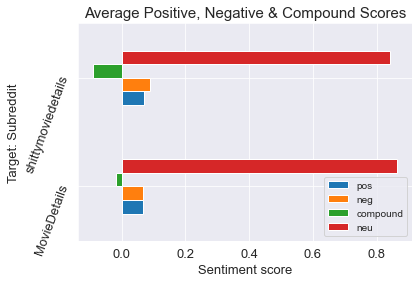

In [174]:
#Plot the average positivity, negativity and compound scores for target
plt.figure(figsize=(15,12));
sentiment_df.groupby('target').mean()[['pos', 'neg', 'compound', 'neu']].plot(kind='barh');
plt.title('Average Positive, Negative & Compound Scores', size = 15);
plt.xticks(size=13);
plt.yticks(size=13, rotation = 70);
plt.ylabel('Target: Subreddit', size=13);
plt.xlabel('Sentiment score', size=13);
plt.savefig('../images/sentiment.jpg');

Interesting, interesting! We may have our first strong signal and indication of separation between our subreddits here. It seems that our Sh-tty Movies, unsurprisingly, contain a bit more negative content. But surprisingly, they also contain a lot more mixed content. The amount of positive content is about identical across the subreddits. But mostly, the posts are primarily neutral across the board.

In [57]:
#pair-plot relationships btn. top words / sentiment and word length etc. - if time

### Vectorize text in prep for analysis

We will need to vectorize our words, for our models to process them. 
We will vectorize self-text, as well as, potentially, title and / or our joint text column to train on.

In [58]:
#initialize CV transformer
cvec = CountVectorizer(stop_words='english', max_features = 500)

### Word analysis

In [59]:
#fit and tansform the vectorizer
word_counts = cvec.fit_transform(df['all_text'])

In [60]:
type(word_counts)

scipy.sparse.csr.csr_matrix

In [61]:
#make it a df
counts = pd.DataFrame(word_counts.todense(), columns=cvec.get_feature_names())

How many total words do we have in the post column?

In [62]:
counts.sum().sum()
#note: identical calc to doing this as `word_counts.sum()`

104126

Let's create a new column called "post length" that calculates the words contained in a post's body.

In [63]:
#get length of posts
df['post_length'] = df['all_text'].map(lambda x: len(x.split()))

In [64]:
#take a peek
df.sort_values(by = 'all_text', ascending = False).head()

,index,title,selftext,subreddit,created_utc,author,is_self,score,num_comments,timestamp,all_text,post_length
8049,257,zad 21 egzamin o mioklasisty 2018 matematyka,,MovieDetails,1970-01-01 00:00:01.619026377,Johnino19,False,1,2,2021-04-21,zad 21 egzamin o mioklasisty 2018 matematyka.,7
2729,2946,your daily trivia,,shittymoviedetails,1970-01-01 00:00:01.611216624,a14alo,False,1,0,2021-01-21,your daily trivia.,3
10627,3363,yeah maybe just change it to In the end scene of Another Round 2020 Martin played by Mads Mikkelsen does some ballet dancing This is a direct reference to Mads Mikkelsen s past career as a ...,Video Link source link Thanks to Reddit users Tokyono and Numerous Lemons for helping out,MovieDetails,1970-01-01 00:00:01.610206725,zzuhruf,True,1,2,2021-01-09,yeah maybe just change it to In the end scene of Another Round 2020 Martin played by Mads Mikkelsen does some ballet dancing This is a direct reference to Mads Mikkelsen s past career as a ...,54
14586,7859,wonderwoman 1984,,MovieDetails,1970-01-01 00:00:01.601159049,theniceguy1279,False,1,0,2020-09-26,wonderwoman 1984.,2
3589,3865,wonder woman 1984 full movie download in hindi,,shittymoviedetails,1970-01-01 00:00:01.609435601,sahilbaba2021,False,1,0,2020-12-31,wonder woman 1984 full movie download in hindi.,8


What is the most typical post length?

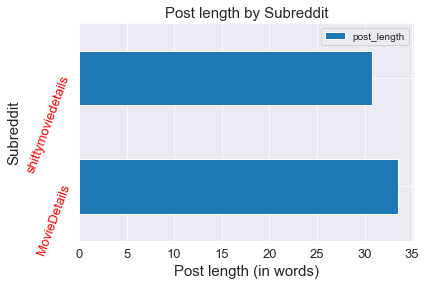

In [65]:
#inspiration from Gwen's NLP lab review
#think about whether the signal here is valuable

df.groupby('subreddit')[['post_length']].mean().plot(kind='barh');
plt.xticks(size=13);
plt.yticks(size=13, rotation = 70, color = 'red'); #rotation added in order to fit labels
plt.ylabel('Subreddit', size=15)
plt.xlabel('Post length (in words)', size=15);
plt.title('Post length by Subreddit', size=15);
plt.savefig('../images/post_length.png')

It seems that post length varies insignificantly by the type of subreddit.

In [66]:
#post length vs. scores
#group by post length being above or below the mean, and look at whether the avg. post score changes
#if time only

What are the most common words?

In [67]:
type(counts)

pandas.core.frame.DataFrame

In [68]:
#word freq analysis - Gwen's lab review code
counts.sum().sort_values(ascending=False).head(30).T

movie        3348
scene        1555
film         1543
character    1204
man          1173
reference    1166
fact          985
actually      909
2020          831
2019          830
time          824
just          813
like          772
seen          676
star          658
says          628
director      589
real          584
end           554
played        549
spider        516
later         514
movies        512
people        503
new           490
john          482
actor         481
2017          465
wars          463
2021          461
dtype: int64

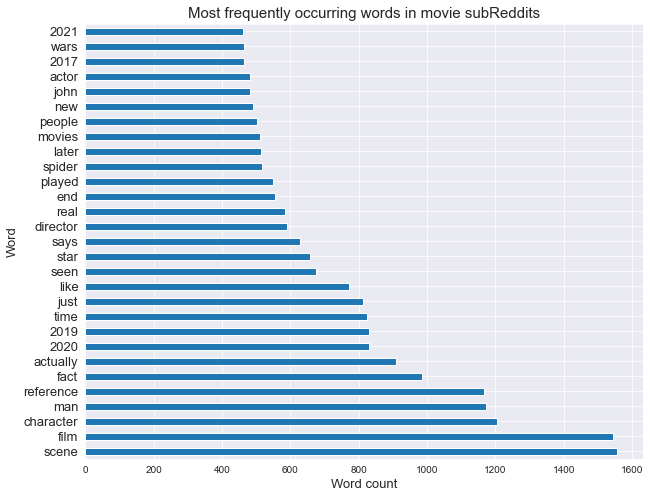

In [69]:
#Gwen's lab review code
plt.figure(figsize=(10,8))
counts.sum().sort_values(ascending=False).head(30)[1:].plot(kind='barh');
plt.title('Most frequently occurring words in movie subReddits', size = 15);
plt.xlabel('Word count', size =13);
plt.yticks(size=13);
plt.ylabel('Word', size=13);
plt.savefig('../images/word_freq.png')

Ok, so words like 'movies', 'director', 'character' and 'played' come up a lot. This is not particularly exciting and would be expected for a movie themed post. 

We also see som intersting ones like 'star' and 'spider'. It may not be conclusive, yet, what these refer to. So -- let's see if we can get more meaning out of these, by looking at word pairs.

In [70]:
#look at bi-grams / tri-grams
#consult Gwen's NLP lab review notebook (fb status analysis) for this!
cvec2 = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features = 30)
ngram = cvec2.fit_transform(df['selftext'])
ngrams = pd.DataFrame(ngram.todense(), columns = cvec2.get_feature_names())

In [71]:
type(ngrams)

pandas.core.frame.DataFrame

In [72]:
ngrams.columns

Index(['2008 interesting', 'blue tank', 'didn want', 'does know', 'don know',
       'easter egg', 'end movie', 'interesting share', 'iron man', 'just like',
       'just noticed', 'le marq', 'long time', 'look like', 'looks like',
       'lt gt', 'main character', 'movie scene', 'peter parker', 'point view',
       'pretty sure', 'processing img', 'scene movie', 'seen movie',
       'tai lung', 'takes place', 've seen', 'view poll', 'watching movie',
       'years ago'],
      dtype='object')

In [73]:
ngrams.shape

(15417, 30)

In [74]:
bigrams = [col for col in ngrams.columns if len(col.split()) == 2]

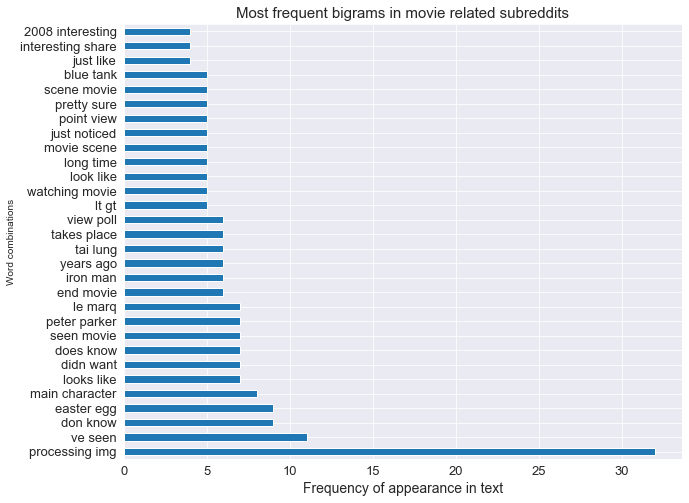

In [75]:
plt.figure(figsize= (10,8))
ngrams[bigrams].sum().sort_values(ascending = False).head(30).plot(kind='barh');
plt.title('Most frequent bigrams in movie related subreddits', size = 15);
plt.yticks(size=13)
plt.xticks(size=13)
plt.xlabel('Frequency of appearance in text', size=14)
plt.ylabel('Word combinations')
plt.savefig('../images/bigrams.png');

These are much more interesting and telling previews -- we can start to piece some context together about what people are talking about! These really start to tell some more interesting stories now; we can see things like 'iron man' and 'peter parker' appearing in here. And that is probably also why we saw 'spider' referenced in the unigrams.

In [76]:
#stemming / lemmatizing -- if time

In [77]:
#parts of speech -- if time

We have a bit of interesting insights and possible signals to dig into. Let's see how the machine views these.

- - -
## Part IV: Modeling

Several classification models are availed to us. We will try the merits of different ones, potentially including the following, and looking for a good mix of interpretability and predictive power, as well as ability to process our rich feature set.

* KNN -- does not work well with many features
* Decision Trees
* Random Forest
* Bayes
* Logistic regression (NOTE: this one might only make sense if we find some linearity in earlier text relationship analysis)
* Boosting -- does not work well with lots of features

We will tune and random-search for best parameters, where appropriate.

### Transform and preprocess

We are going to keep our data composition simple and train primarily on our primary text field as well as post sentiment, to predict the target. As we saw, things like post length and number of comments were barely distinguishable, and based on the total size of the reddit, the number of authors would be a little disproportionate but not a true signal of how the data might perform based on just that skew. So let's leave those factors off.

We are going to use our trusted count vectorizer again; this time, to prep for modeling.

In [78]:
#what's in our current df?
sentiment_df.head(2)

,index,neg,neu,pos,compound,all_text,target
0,0,0.0,1.0,0.0,0.0,In the movie Bullworth 1998 a police officer is seen not shooting black people .,shittymoviedetails
1,1,0.0,1.0,0.0,0.0,The Nightmare Before Christmas 1993 when he arrives at Christmas Town Jack sings what s this There s white things in the air 22 seconds later he sings there are children throwing snowball...,shittymoviedetails


In [79]:
#instantiate cvec
cvec_modeling = CountVectorizer(
    stop_words = 'english', 
    max_features = 5_000, #init guess for efficiency; + use grid search? (optional)
    ngram_range=(1, 2), #uni + bi-grams
) #tinker w/ max features dep. on how long runs

It's time time define our features set. We are using sentiment and our text.

In [89]:
#new word array w/ cvec transform; set X and y
cvec_df = cvec_modeling.fit_transform(sentiment_df['all_text'])
cvec_df=pd.DataFrame(cvec_df.todense(), columns = cvec_modeling.get_feature_names())
features=pd.concat([cvec_df, sentiment_df],axis=1)#, ignore_index=True)
X = features.drop(
    columns = ['target', 'all_text','index']) #been vectorized; drop unnecessary index we created on concat
feature_names = X.columns
#X = np.array(X) 
y = (sentiment_df['target']) #np.array

In [143]:
features.shape

(15417, 5007)

In [90]:
#expecting ~5k features based on the params we set
X.shape

(15417, 5003)

Let's split off our training and prediction data now.

In [91]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 42)

Let's map our baseline predictions for our classes, which are the ones for the model to beat.

In [85]:
#baseline pred
sentiment_df['target'].value_counts(normalize=True)

shittymoviedetails    0.507038
MovieDetails          0.492962
Name: target, dtype: float64

Looks like we have pretty evenly distributed classes to start out. It's almost as if... a post has a 50/50 shot of being in either. So, I expect the classifier to struggle with choosing or making an opinion on the posts, but let's see, if we can beat the baseline.

I want a random forest to see if we can get different opinions and the wisdom of the crowd to get us some likely predictions!

### Model 1: Random forest

Let's first try this out of the box.

In [123]:
#instantiate
forest = RandomForestClassifier()

#fit on the train
forest.fit(X_train,y_train)

(0.9944646254973188, 0.7400778210116732)

In [124]:
#score on train and test
forest.score(X_train, y_train).round(4), forest.score(X_test, y_test).round(4)

(0.9945, 0.7401)

Initial model is pretty overfit, but not terrible.

Let's break out the feature importances!

In [154]:
feature_importances = pd.DataFrame(zip(
    feature_names, forest.feature_importances_), columns = ['feature','importance'])

#drop index
feature_importances = feature_importances.set_index('feature')
feature_importances.sort_values(by = 'importance', ascending = False).head(70)

,importance
feature,
neu,0.017968
fact,0.017462
compound,0.016446
neg,0.016218
pos,0.012302
...,...
club,0.001129
real,0.001128
wonder woman,0.001120


It comes as no surprise that our sentiment features really did have some weight.

It's also no surprise that, with thousands of word-features in the matrix, each word would have fairly nominal weight on the model overall.

The feature selection we see here in the end is disappointingly challenging to interpet. In retrospect, I should have probably removed stop words like ‘movie’ before training the model.

I'll tune my forest using grid search, for simplicity.

In [103]:
#param grid -- combination models to grid search over for ideal params; high-low strat,
#for efficiency (Devin)

params = {
    'n_estimators': [25, 100],
    'max_depth': [1, 4, 16], #trial
    'max_features': [None,'auto']
}

In [104]:
#check cores on machine -- spread out our computing power
cores = os.cpu_count()
cores

In [116]:
#instantiate transformer, estimator
#also implement param grid here (ideally)
forest = RandomForestClassifier() 

grid_search_cv = GridSearchCV(forest, param_grid = params, n_jobs = -1, verbose=1, cv = 2)
#-1 n jobs uses all avail. cores

#fit on train
grid_search_cv.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.5min finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 4, 16],
                         'max_features': [None, 'auto'],
                         'n_estimators': [25, 100]},
             verbose=1)

In [118]:
grid_search_cv.best_score_.round(4)

0.6771

In [119]:
grid_search_cv.best_params_

{'max_depth': 16, 'max_features': 'auto', 'n_estimators': 100}

In [109]:
preds = grid_search_cv.predict(X_test)

In [125]:
grid_search_cv.score(X_train, y_train).round(4), grid_search_cv.score(
    X_test, y_test).round(4)

(0.7632, 0.6918)

These scores are much closer together, which tells me, it's probably a better fit than the out of the box model, although the accuracy is worse. However, we are still beating the baseline.

In [168]:
type(y_test)

pandas.core.series.Series

In [171]:
#match test and pred shape to build confusion matrix
y_test.drop(y_test.index[0], inplace=True)
y_test.shape

(3855,)

In [175]:
#add confusion matrix, all the other class. metrics -- sensitivity, precision, recall, etc.
#tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() -- need to troubleshoot this

### Model 2: Decision Trees

In [177]:
#I probably will need to re-split train test on mod target; so let's redefine it up above, if needed

We are going to repeat our workflow now on one more highly interpreable and visualizable model: decision trees. Our data set is pretty well balanced, so this should not be a problem, and decision trees are supposed to run fast -- a good tool for a data scientist short on time.

Note: Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data. [source](https://www.google.com/search?q=do+i+need+to+scale+before+running+decision+tree&oq=do+i+need+to+scale+before+running+decision+tree&aqs=chrome..69i57j33i160j33i299.7672j0j7&sourceid=chrome&ie=UTF-8)

In [178]:
#repeat workflow
#remember to scale - NOTE: not req. for trees
#remember to tune params (optional for Bayes)

#instantiate tree
dt = DecisionTreeClassifier(random_state =42)

In [182]:
#fit simple tree
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [185]:
# Evaluate model.
#print(f'Score on training set: {dt.score(X_train, y_train)}')
#print(f'Score on testing set: {dt.score(X_test, y_test)}')
#code breaks! - revisit

In [186]:
#rerun with hyper-params

# Instantiate model with:
# - a maximum depth of 5.
# - at least 7 samples required in order to split an internal node.
# - at least 3 samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

dt_tuned = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=7,
    min_samples_leaf=3,
    ccp_alpha=0.1,
    random_state =42) #instantiate

In [187]:
#fit tuned tree
dt_tuned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.1, max_depth=5, min_samples_leaf=3,
                       min_samples_split=7, random_state=42)

In [190]:
# Evaluate model.
#print(f'Score on training set: {dt_tuned.score(X_train, y_train).round(4)}')
#print(f'Score on testing set: {dt_tuned.score(X_test, y_test).round(4)}')

#breaks - revisit

In [191]:
#grid search the tree
params = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 3, 5],
    'ccp_alpha': [0, 0.01, 0.1, 1]
}

In [192]:
#instantiate grid searched tree
dt_grid_searched = DecisionTreeClassifier(random_state=42)

In [193]:
#fit tree
gs = GridSearchCV(dt_grid_searched, params, cv = 3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1],
                         'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [5, 10, 20]})

In [194]:
gs.best_params_

{'ccp_alpha': 0,
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [195]:
gs.best_score_.round(4)

0.6031

In [202]:
# Evaluate model.
#print(f'Score on training set: {gs.score(X_train, y_train).round(4)}')
#print(f'Score on testing set: {gs.score(X_test, y_test).round(4)}')

In [203]:
#get preds
tree_preds = gs.predict(X_test)

In [205]:
#tn, fp, fn, tp = confusion_matrix(y_test, tree_preds).ravel()

#print(confusion_matrix(y_test, tree_preds))

In [206]:
#plot confusion matrix as well

In [208]:
#get sensitivity
#sense = tp/(tp+fn) #true pos over all pos
#print(f'Sensitivity: {round(sense, 4)}')

In [ ]:
#get specificity
#spec = tn/(tn + fp) #true neg over all neg
#print(f'Specificity: {round(spec, 4)}')

In [ ]:
#get classes -- NOTE: can use the .classes_ param as well
df['subreddit'].value_counts()

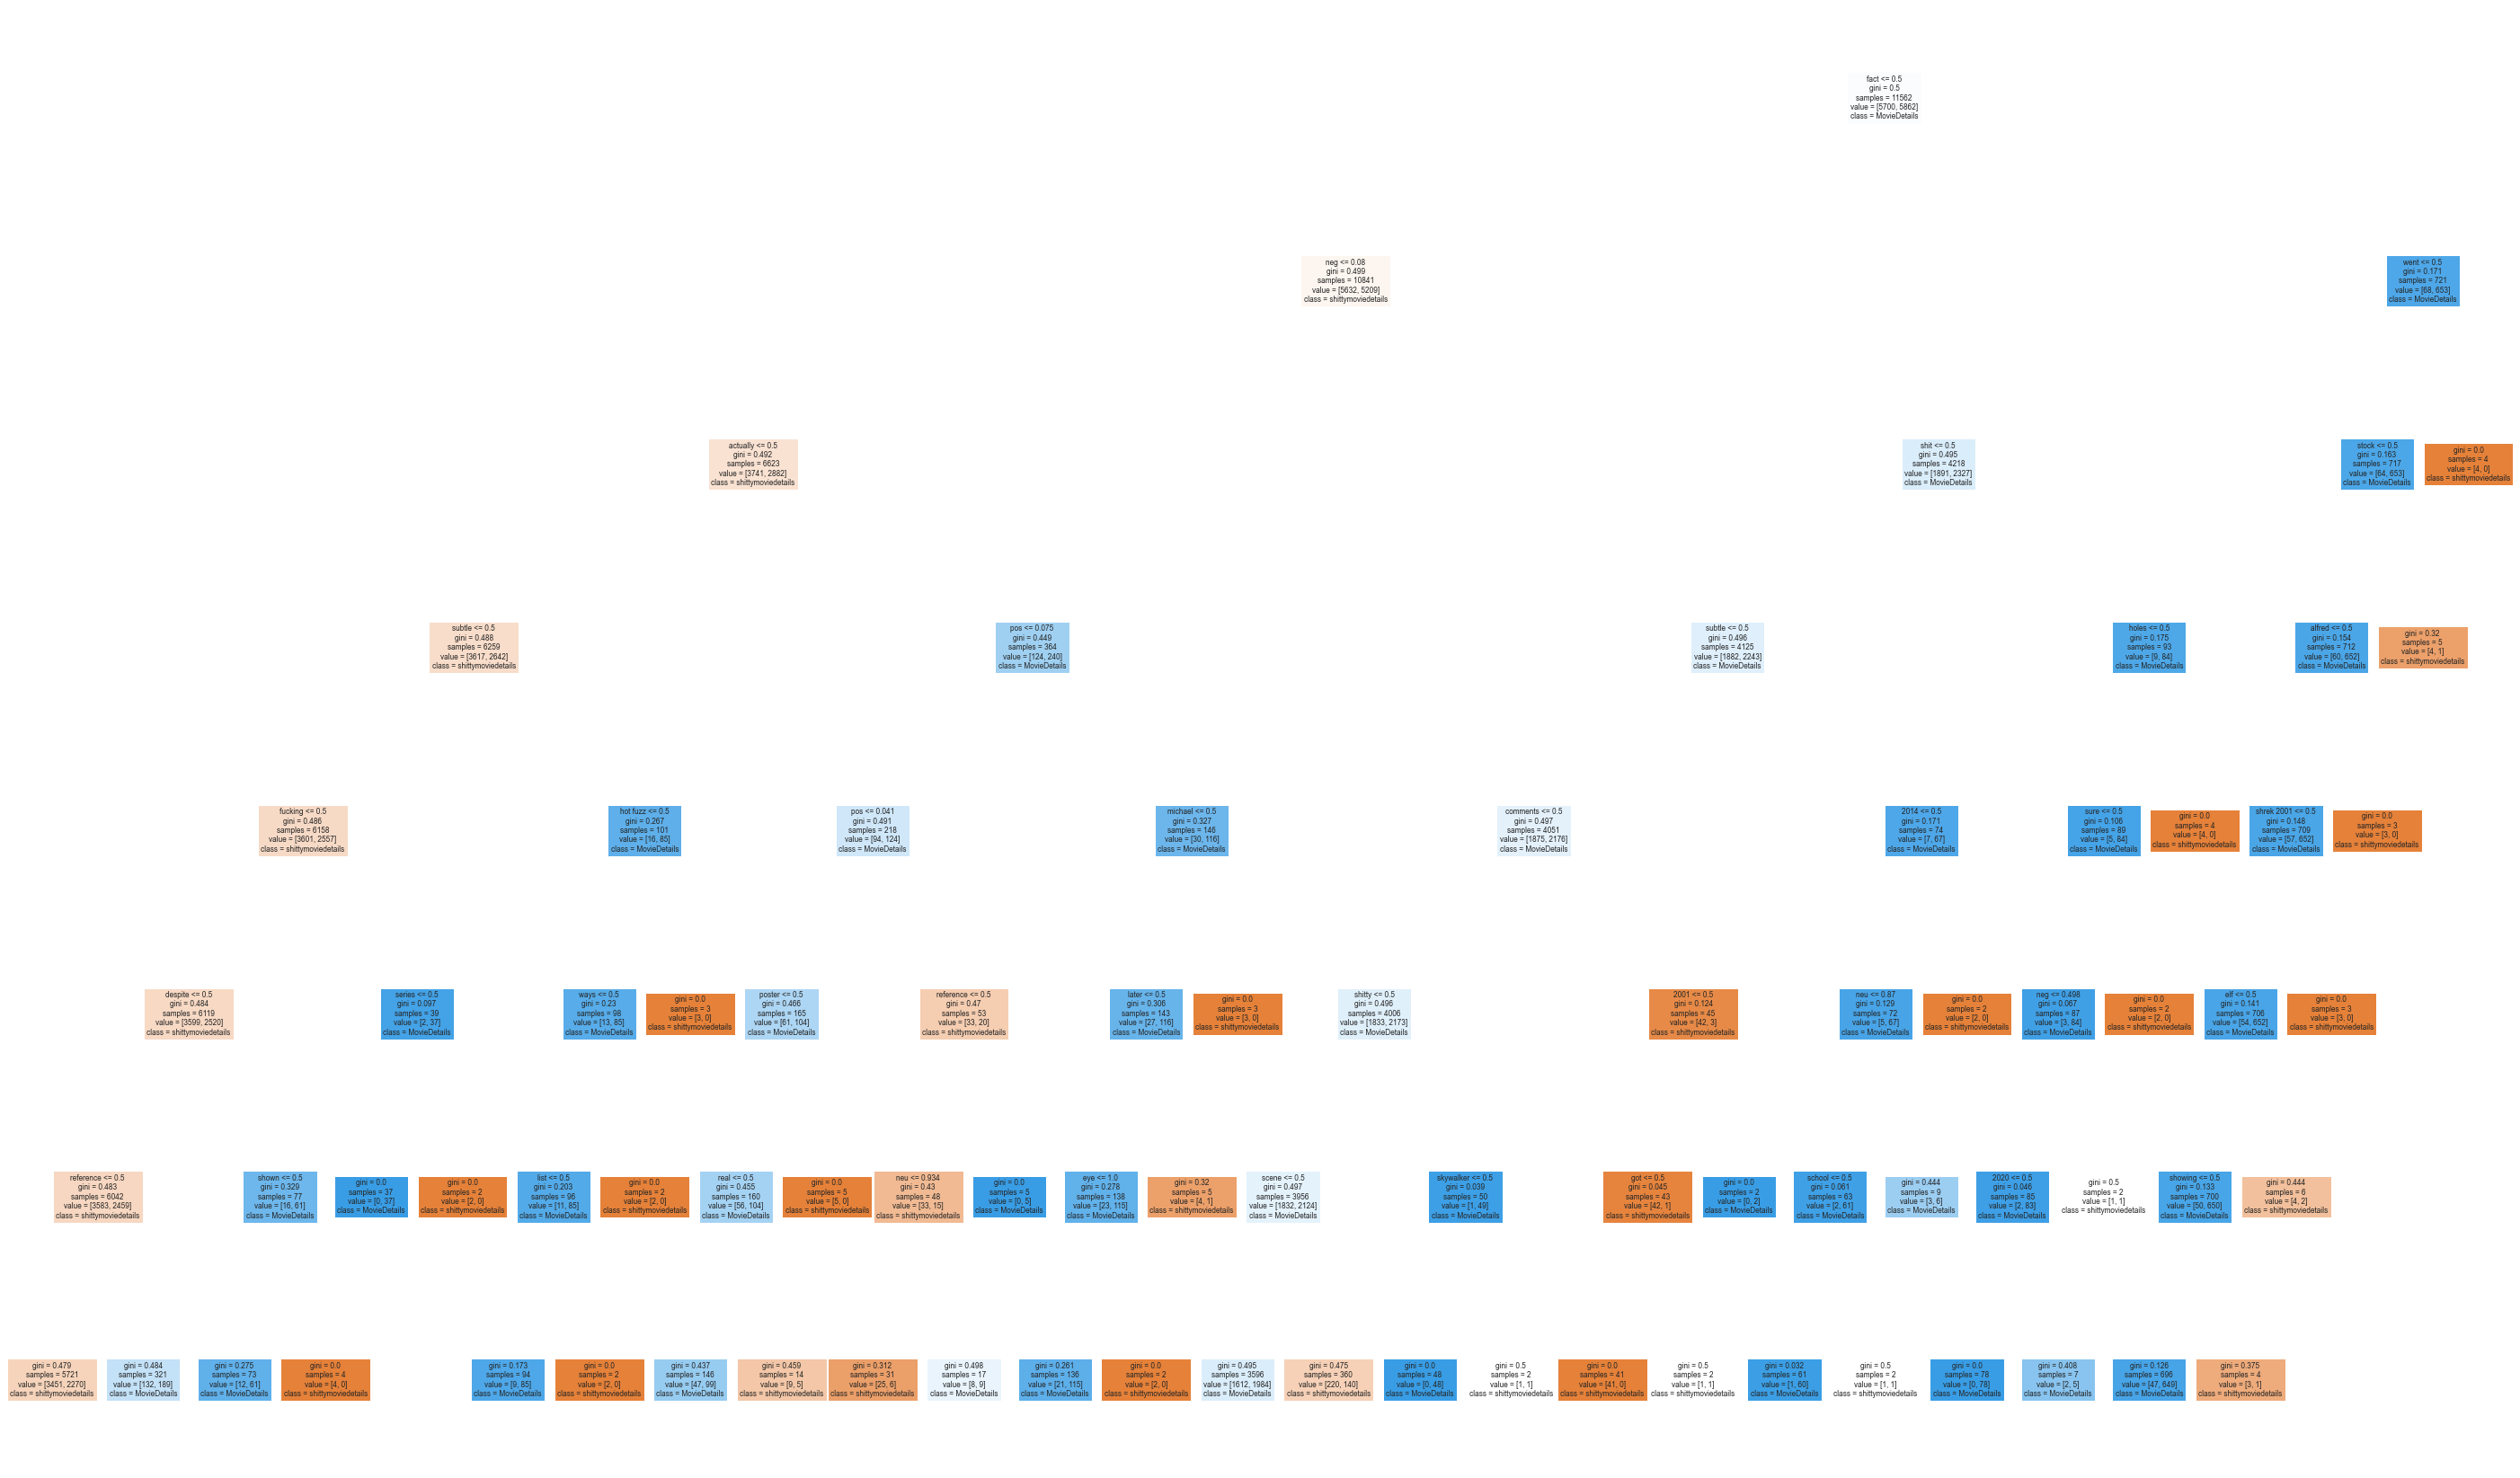

In [211]:
#visualization: how the forest picks the splits - nice to have

# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(gs.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['shittymoviedetails', 'MovieDetails'],
          filled = True);


#save graphic

plt.savefig('../images/tree.png')

- - -
## Part V - Conclusions

We chose to keep our data composition simple and train primarily on our joint title-selftext (post) text field as well as post sentiment, to predict the target. We did not pick up a lot of signal during EDA from attributes like number of comments or posts per author, so these did not wind up being selected for purposes of modeling.

Our classes were distributed pretty evenly, and this helped to some extent determine our modeling strategy. 

Based on our accuracy score, the Random Forest model was 69% accurate at predicting the right class; which is better than the 50/50 baseline shot, since we did not really have a strong majority class to start out. We think that the random forest model had decent predictive power, but ultimately, our topics are just too similar for this model to predict very well.

In part, there may be less than stellar aha!s here, because we do have some noise words in our vectorized text data, including "easter egg", "movies", and the like, which add no real value to training or separating our data and may likely appear in any movie related subreddit. In retrospect, amending our `stopwords` list to exclude these terms from training may have improved our accuracy by a bit. We see similar results when reviewing our model feature importance, where many noisy words come up merely due to their frequency.

Sentiment turned out to be strongest decypherable signal and indication of separation between our subreddits here. It seems that our Sh-tty Movies, unsurprisingly, contain a bit more negative content or mixed-sentiment content. The amount of positive content is about identical across the subreddits, and most posts are scored as neutral by our sentiment analyzer. (We definitely anticipated the "regular" movie detail subreddit to be mostly neutral, and this is good signal confirmation.)

When we set out to model, we expected that comparing two very closely related topics for purposes of classification -- particularly, with rather sparse text data and with a lot of humorous sentiment (read: images, lore, cliches and idioms) would present challenges, for purposes of natural language processing interpretation and classification.

In the future, Support Vector Machines may be attempted in order to try to bring in some more of the computer vision on the images and improve our model (although PushShift API may not be sufficient here for scraping purposes, and more selective sampling required).

The goal of this particular exploration was always to have some fun with text data, and, for our game of trivia, fun may be the more important factor than model accuracy. In the end, this is not necessarily a model worthy of production, even if the machine accuracy did beat our crowd predictions (by a negligible amount), during the live game simulation.